In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

D:\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
microsoft_5y = pd.read_csv("C:\\Users\\Jitendra Sharma\\Downloads\\MSFT.csv", index_col='Date', parse_dates=["Date"])
#test_set = pd.read_csv("C:\\Users\\Jitendra Sharma\\Downloads\\MSFT (3).csv")

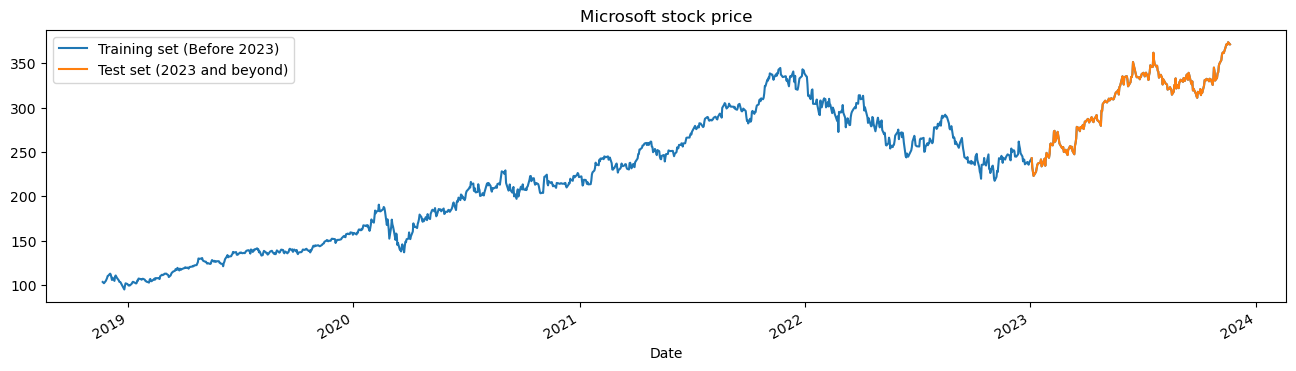

In [4]:
# Plot the training set
microsoft_5y["Open"][:'2023'].plot(figsize=(16, 4), legend=True)
# Plot the test set
microsoft_5y["Open"]['2023':].plot(figsize=(16, 4), legend=True)
plt.legend(['Training set (Before 2023)', 'Test set (2023 and beyond)'])
plt.title('Microsoft stock price')
plt.show()

In [5]:
training_set = microsoft_5y[:'2023'].iloc[:, 1:2].values
test_set = microsoft_5y['2023':].iloc[:,1:2].values

In [6]:
# Feature Scaling with normalization as we use that with RNN

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
x_train = []
y_train = []

for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
# Converting x_train and y_train into numpy array

x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
x_train.shape
# Let's reshape , as RNN takes in 3D format

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

x_train.shape

(1197, 60, 1)

In [9]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
model_srnn = Sequential()

# adding first RNN layer and dropout regulatization
model_srnn.add(SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (x_train.shape[1],1))
             )

model_srnn.add(Dropout(0.2))


# adding second RNN layer and dropout regulatization

model_srnn.add(SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

model_srnn.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

model_srnn.add(SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

model_srnn.add(Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

model_srnn.add(
    SimpleRNN(units = 50)
             )

model_srnn.add(
    Dropout(0.2)
             )

# adding the output layer
model_srnn.add(Dense(units = 1))

# compiling RNN
model_srnn.compile(
    optimizer = "adam", 
    loss = "mean_squared_error")


In [10]:
srnn_model = model_srnn.fit(x_train, y_train, epochs = 50, batch_size=120, validation_split = 0.2)

Epoch 1/50
8/8 [==============================] - 7s 235ms/step - loss: 0.6922 - val_loss: 0.1274
Epoch 2/50
8/8 [==============================] - 1s 98ms/step - loss: 0.3980 - val_loss: 0.0821
Epoch 3/50
8/8 [==============================] - 1s 94ms/step - loss: 0.3509 - val_loss: 0.0256
Epoch 4/50
8/8 [==============================] - 1s 93ms/step - loss: 0.2531 - val_loss: 0.0032
Epoch 5/50
8/8 [==============================] - 1s 95ms/step - loss: 0.2223 - val_loss: 0.0089
Epoch 6/50
8/8 [==============================] - 1s 93ms/step - loss: 0.2271 - val_loss: 0.0032
Epoch 7/50
8/8 [==============================] - 1s 95ms/step - loss: 0.2110 - val_loss: 0.0039
Epoch 8/50
8/8 [==============================] - 1s 93ms/step - loss: 0.1930 - val_loss: 0.0089
Epoch 9/50
8/8 [==============================] - 1s 96ms/step - loss: 0.1775 - val_loss: 0.0016
Epoch 10/50
8/8 [==============================] - 1s 91ms/step - loss: 0.1630 - val_loss: 0.0019
Epoch 11/50
8/8 [===========

In [16]:
# Getting predicted stock prices of month Nov 2022
# Concatination
dataset_total = pd.concat((microsoft_5y['Open'][:'2023'], microsoft_5y['Open']['2023':]), axis=0)

# Stock prices of previous 60 days for each day of Nov 2022
inputs = dataset_total[len(dataset_total)-len(test_set)-60:].values


# Converting this dataframe into numpy array.
inputs = inputs.reshape(-1,1)

# Feature Scaling
inputs = sc.transform(inputs)

# Creating a test set.
x_test = []
for i in range(60, len(inputs)):  # 80 for 20 days in novermber.
    x_test.append(inputs[i-60:i, 0])
    
# Convert in numpy array
x_test = np.array(x_test)

# Convert into 3D
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Getting predicted stock prices
predicted_stock_price_srnn = model_srnn.predict(x_test)
predicted_stock_price_srnn = sc.inverse_transform(predicted_stock_price_srnn)
predicted_stock_price_srnn.shape

7/7 [==============================] - 0s 29ms/step


(223, 1)

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# actual values

# predicted values

# calculate MSE
mse = mean_squared_error(test_set, predicted_stock_price_srnn)

# calculate RMSE
rmse = sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)


MSE: 577.401684988319
RMSE: 24.029184026685527


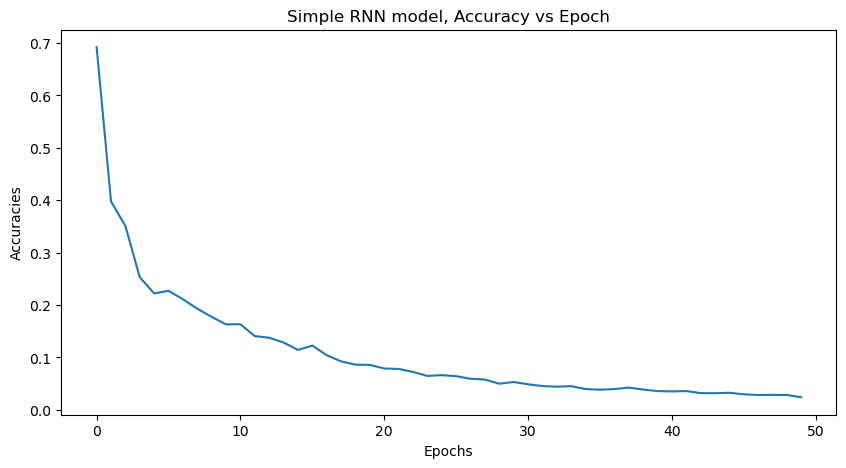

In [13]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(srnn_model.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

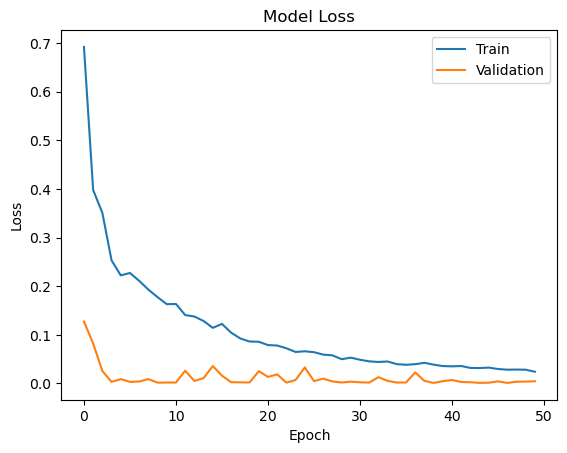

In [14]:
import matplotlib.pyplot as plt

# assuming history is a dictionary containing the loss and validation loss values
plt.plot(srnn_model.history['loss'])
plt.plot(srnn_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


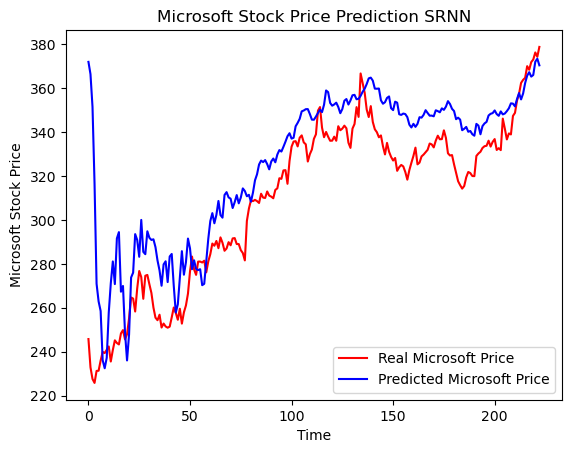

In [15]:
import matplotlib.pyplot as plt
plt.plot(test_set, color = "red", label = "Real Microsoft Price")
plt.plot(predicted_stock_price_srnn, color = "blue", label = "Predicted Microsoft Price")

plt.title("Microsoft Stock Price Prediction SRNN")
plt.xlabel("Time")
plt.ylabel("Microsoft Stock Price")
plt.legend()
plt.show()